In [1]:
pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform

import cv2
import numpy as np
import math
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageFilter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_PATH = "/content/drive/MyDrive/Retinal_Images_Dataset/original-images"

In [5]:
import os
import cv2
import h5py
import numpy as np
import torch
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter

OUTPUT_TRAIN_PATH = "train_data.h5"
OUTPUT_TEST_PATH = "test_data.h5"
random_crop = 30
patch_size = 32
label_size = 20
conv_side = 6
scale = 4
block_step = 16
block_size = 32

def save_patches(patches, folder):
    # Create the folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    for i, patch in enumerate(patches):
        filename = f"{folder}/patch_{i}.png"
        patch_scaled = (patch * 255).astype(np.uint8)
        cv2.imwrite(filename, patch_scaled)

def prepare_train_data(image_path):

    hr_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb) #YCrCb separates the grayscale information from the color information allowing for more efficient compression and processing of image data.
    hr_img = hr_img[:, :, 0] #converts the image from YCrCb color space to grayscale by discarding color information
    shape = hr_img.shape

    """Downsampling by resizing to reduce the number of pixels in the image and
        then upsampling the LR image to be of same size as HR original image"""

    lr_img = cv2.resize(hr_img, (int(shape[1] / scale), int(shape[0] / scale))) #shape[1] is the width of the original (HR) image, shape[0] is the height of the original image.
    # print("Low Reso image after downsample: ", lr_img.shape)
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    # print("Low Reso image after resizing to size of HR image: ", lr_img.shape)

    """Calculate the number of non-overlapping blocks that can fit within the width and
    height of the image for extracting patches from image"""

    width_num = int((shape[0] - (block_size - block_step) * 2) / block_step) #(block_size - block_step) * 2 calculates the total overlap introduced by the blocks in the height dimension
    height_num = int((shape[1] - (block_size - block_step) * 2) / block_step)

    data = []
    label = []
    hr_patches = []
    lr_patches = []

    for k in range(width_num):
        for j in range(height_num):
            x = k * block_step #Starting coordinates (x and y) of the current block
            y = j * block_step

            #Extract patches from both the HR image and the LR image
            hr_patch = hr_img[x: x + block_size, y: y + block_size]
            lr_patch = lr_img[x: x + block_size, y: y + block_size]

            # Data Augmentation
            if random.random() > 0.5:
                hr_patch = np.fliplr(hr_patch)
                lr_patch = np.fliplr(lr_patch)

            if random.random() > 0.5:
                hr_patch = np.flipud(hr_patch)
                lr_patch = np.flipud(lr_patch)

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            #convert patch to pytorch tensor
            lr = torch.from_numpy(lr_patch).unsqueeze(0).float()  #input image is grayscale so unsqueeze(0) is used to add batch dimension and channel dimen
            hr = torch.from_numpy(hr_patch[conv_side: -conv_side, conv_side: -conv_side]).unsqueeze(0).float()
            # hr = torch.from_numpy(hr_patch).unsqueeze(0).float()

            # lists to hold the LR and HR patches for all blocks within the specific image
            data.append(lr)
            label.append(hr)

            #For saving the image pathces
            hr_patches.append(hr_patch)
            lr_patches.append(lr_patch)

    hr_patches = np.array(hr_patches)
    lr_patches = np.array(lr_patches)
    """
    save_patches(hr_patches, 'hr_patches_train')
    save_patches(lr_patches, 'lr_patches_train') """

    data = torch.stack(data)
    label = torch.stack(label)

    return data, label


#### Image Visualization

Shape of Original HR Image: (605, 700, 3)
Shape of LR Image: (605, 700, 3)
Size of High Resolution Patch: (20, 20)
Size of Low Resolution Patch: (32, 32)



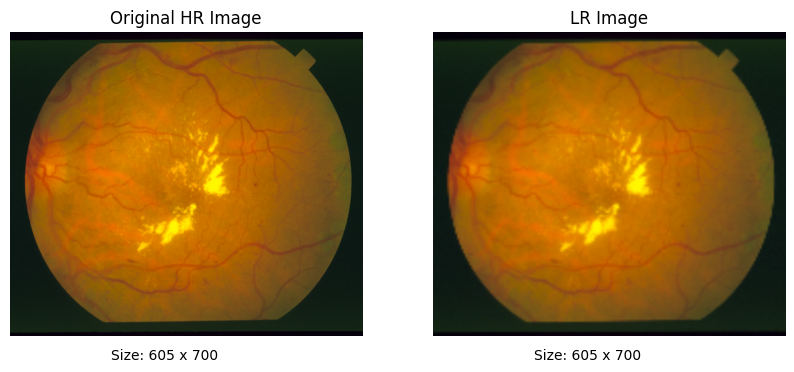

In [6]:
import matplotlib.pyplot as plt

# Load an image and its corresponding HR image
image_path = "/content/drive/MyDrive/Retinal_Images_Dataset/original-images/im0001.ppm"
lr_patch, hr_patch = prepare_train_data(image_path)
original_image = plt.imread(image_path)
# print(lr_patch.shape)
# print(hr_patch.shape)
shape = original_image.shape

scale = 4

lr_img = cv2.resize(original_image, (int(shape[1] / scale), int(shape[0] / scale))) #shape[1] is the width of the original (HR) image, shape[0] is the height of the original image.
# print("Size of LR Image after downsampling:", lr_img.shape)
lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
# print("Size of LR Image after resizing to size of HR Image:", lr_img.shape)

# Select one LR patch and its corresponding HR patch
index = 20
lr = lr_patch[index].squeeze().numpy()
hr = hr_patch[index].squeeze().numpy()
lr_size = lr.shape
hr_size = hr.shape

print("Shape of Original HR Image:", original_image.shape)
print("Shape of LR Image:", lr_img.shape)
print("Size of High Resolution Patch:", hr_size)
print("Size of Low Resolution Patch:", lr_size)
print("")

# Plot all three images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original HR Image')
plt.axis('off')
plt.text(200, 650, f'Size: {original_image.shape[0]} x {original_image.shape[1]}', color='black')

plt.subplot(1, 2, 2)
plt.imshow(lr_img)
plt.title('LR Image')
plt.axis('off')
plt.text(200, 650, f'Size: {lr_img.shape[0]} x {lr_img.shape[1]}', color='black')

plt.show()


In [7]:
# Define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
    # Convert images to torch tensors
    target_data = torch.tensor(target, dtype=torch.float)
    ref_data = torch.tensor(ref, dtype=torch.float)

    # Calculate the squared difference between the two images
    diff = ref_data - target_data
    mse = torch.mean(diff ** 2)

    # Calculate PSNR
    psnr_value = 20 * torch.log10(255. / torch.sqrt(mse))
    return psnr_value.item()

# Define function for mean squared error (MSE)
def mse(target, ref):
    # Convert images to torch tensors
    target_data = torch.tensor(target, dtype=torch.float)
    ref_data = torch.tensor(ref, dtype=torch.float)

    # Calculate the squared difference between the two images
    diff = ref_data - target_data
    mse_value = torch.mean(diff ** 2)

    return mse_value.item()

# Define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    return scores

psnr_value = psnr(original_image, lr_img)
mse_value = mse(original_image, lr_img)
comparison_score = compare_images(original_image, lr_img)

# psnr_value_patch = psnr(original_image, lr)
# mse_value_patch = mse(original_image, lr)

print("PSNR between HR and LR images:", psnr_value)
print("MSE between HR and LR images:", mse_value)
print("Comparison scores :", comparison_score)


# print("PSNR between HR and LR Patch:", psnr_value_patch)
# print("MSE between HR and LR Patch:", mse_value_patch)

PSNR between HR and LR images: 38.71158218383789
MSE between HR and LR images: 8.748262405395508
Comparison scores : [38.71158218383789, 8.748262405395508]


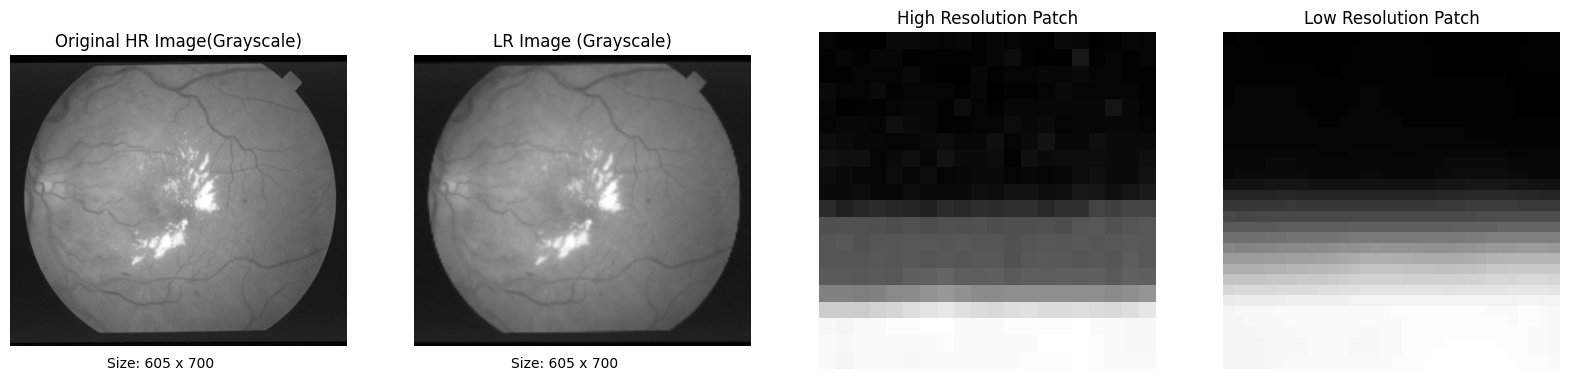

In [8]:
# Plot all three images side by side
plt.figure(figsize=(20, 8))

# Convert the RGB image to grayscale
gray_image_original = Image.fromarray(original_image).convert('L')
gray_image_lr = Image.fromarray(lr_img).convert('L')

plt.subplot(1, 4, 1)
plt.imshow(gray_image_original, cmap='gray')
plt.title('Original HR Image(Grayscale)')
plt.axis('off')
plt.text(200, 650, f'Size: {original_image.shape[0]} x {original_image.shape[1]}', color='black')

plt.subplot(1, 4, 2)
plt.imshow(gray_image_lr, cmap='gray')
plt.title('LR Image (Grayscale)')
plt.axis('off')
plt.text(200, 650, f'Size: {lr_img.shape[0]} x {lr_img.shape[1]}', color='black')

plt.subplot(1, 4, 3)
plt.imshow(hr, cmap='gray')
plt.title('High Resolution Patch')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(lr, cmap='gray')
plt.title('Low Resolution Patch')
plt.axis('off')
plt.show()

In [9]:
def prepare_test_data(image_path):
    hr_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    shape = hr_img.shape

    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]

    lr_img = cv2.resize(hr_img, (int(shape[1] / scale), int(shape[0] / scale)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

    """ Generate random coordinates (x and y) within the image boundaries to crop LR and HR image patches,
        ensure that different patches are sampled each time the function is called. So generate random patches
        from different regions of the image """
    data = []
    label = []
    for _ in range(random_crop):
        x = np.random.randint(0, min(shape[0], shape[1]) - patch_size)
        y = np.random.randint(0, min(shape[0], shape[1]) - patch_size)

        lr_patch = lr_img[x: x + patch_size, y: y + patch_size]
        hr_patch = hr_img[x: x + patch_size, y: y + patch_size]

        lr_patch = lr_patch.astype(float) / 255.
        hr_patch = hr_patch.astype(float) / 255.

        lr = torch.from_numpy(lr_patch).unsqueeze(0).float()
        hr = torch.from_numpy(hr_patch[conv_side: -conv_side, conv_side: -conv_side]).unsqueeze(0).float()
        # hr = torch.from_numpy(hr_patch).unsqueeze(0).float()


        data.append(lr)
        label.append(hr)

    data = torch.stack(data)
    label = torch.stack(label)

    return data, label

In [10]:
if __name__ == "__main__":
    # Load original images
    original_images = [os.path.join(DATA_PATH, img) for img in os.listdir(DATA_PATH)]

    # Split dataset into train and test sets
    train_images, test_images = train_test_split(original_images, test_size=0.2, random_state=42)

    # Prepare training data
    train_data = []
    train_label = []
    # count1 = 0
    for img_path in train_images:
        data, label = prepare_train_data(img_path)
        train_data.append(data)
        train_label.append(label)
        # count1 = count1 + 1 #For testing
        # if count1 == 1:
        #      break

    train_data = np.concatenate(train_data)
    train_label = np.concatenate(train_label)

    # Prepare test data
    test_data = []
    test_label = []
    # count2 = 0
    for img_path in test_images:
        data, label = prepare_test_data(img_path)
        test_data.append(data)
        test_label.append(label)
        # count2 = count2 + 1 #For testing
        # if count2 == 5:
        #     break

    test_data = np.concatenate(test_data)
    test_label = np.concatenate(test_label)

    # Write to HDF5 files
    with h5py.File(OUTPUT_TRAIN_PATH, 'w') as h:
        h.create_dataset('data', data=train_data)
        h.create_dataset('label', data=train_label)
        print("Training data written successfully !")

    with h5py.File(OUTPUT_TEST_PATH, 'w') as h:
        h.create_dataset('data', data=test_data)
        h.create_dataset('label', data=test_label)
        print("Testing data written successfully !")

Training data written successfully !
Testing data written successfully !


In [11]:
# View contents of train_dataset
print("Train Data Shape:", train_data.shape)
print("Train Label Shape:", train_label.shape)

print("Test Data Shape:", test_data.shape)
print("Test Label Shape:", test_label.shape)

Train Data Shape: (454895, 1, 32, 32)
Train Label Shape: (454895, 1, 20, 20)
Test Data Shape: (2400, 1, 32, 32)
Test Label Shape: (2400, 1, 20, 20)


### SRCNN Architecture

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=9, padding=0) # Applies 128 filters of size 9x9 (kernel_size=9) to the input image.
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=5, padding=0)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.iden = nn.Identity()
        self.init_weights()  # Initialize weights

    def init_weights(self):
      # Initialize weights using He initialization
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv1(x) #Patch Extraction and Representation with 1st layer using convolutional filters (nn.Conv2d).
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x) #Convolutional Layer 2: Non-linear Mapping -> maps the extracted features to a higher-dimensional space.
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x) #Convolutional Layer 3: Reconstruction of the high-resolution image from the mapped features.
        x = self.iden(x)

        # Apply interpolation to resize the output to match the target label size (20x20)
        x = nn.functional.interpolate(x, size=(20, 20), mode='bilinear', align_corners=False)

        return x

In [70]:
# Instantiate the model
model = SRCNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

criterion = nn.MSELoss()

print(model)


SRCNN(
  (conv1): Conv2d(1, 128, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (iden): Identity()
)


In [71]:
import h5py
import torch
from torch.utils.data import Dataset, DataLoader

class HDF5Dataset(Dataset):
    def __init__(self, file_path):
        self.file = h5py.File(file_path, 'r')
        self.data = self.file['data']
        self.label = self.file['label']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx][0][None, ...]  # Add back singleton dimension
        label = self.label[idx][0][None, ...]
        return data, label

train_dataset = HDF5Dataset('train_data.h5')
test_dataset = HDF5Dataset('test_data.h5')

# View contents of train_dataset
print("Train Dataset:")
for i in range(len(train_dataset)):
    data, label = train_dataset[i]
    print(f"Sample {i}:")
    print("Data Shape:", data.shape)
    print("Label Shape:", label.shape)

    break

Train Dataset:
Sample 0:
Data Shape: (1, 32, 32)
Label Shape: (1, 20, 20)


In [73]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the shape of batches in train_loader
for inputs, labels in train_loader:
    print(f"Batch Input Shape: {inputs.shape}, Batch Label Shape: {labels.shape}")
    break

Batch Input Shape: torch.Size([32, 1, 32, 32]), Batch Label Shape: torch.Size([32, 1, 20, 20])


In [74]:
print(len(train_dataset))
print(len(test_dataset))

print(len(train_loader))
print(len(test_loader))

# Length will be different based on the batch_size. This is way how DataLoader batches the data.

454895
2400
14216
75


Training using CPU : Comment the cell if GPU is being used

In [ ]:
# num_epochs = 2
# batch_size = 64

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     # Print the average loss for the epoch
#     print('[Epoch %d] Average Loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
#     break

# print('Finished Training')


Training using GPU : Comment the following two cells if GPU is being used

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the device
model.to(device)

# Move optimizer state to the same device as the model i.e in GPU
optimizer_state_dict = optimizer.state_dict()
for key in optimizer_state_dict['state'].keys():
    for param_key in optimizer_state_dict['state'][key].keys():
        optimizer_state_dict['state'][key][param_key] = optimizer_state_dict['state'][key][param_key].to(device)
optimizer.load_state_dict(optimizer_state_dict)

Using device: cuda


In [76]:
# import os

# num_epochs = 30
# checkpoint_interval = 10  # Save checkpoint every 10 epochs
# checkpoint_dir = 'checkpoints'

# # Ensure checkpoint directory exists
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(train_loader):
#         # Move inputs and labels to the device
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to prevent exploding gradients
#         optimizer.step()
#         running_loss += loss.item()

#     # Update the learning rate scheduler
#     scheduler.step(running_loss / len(train_loader))

#     # Get the current learning rate
#     current_lr = scheduler.get_last_lr()[0]

#     # Print epoch details and loss after each epoch
#     print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.4f}, Learning Rate: {current_lr:.4f}')

#     # Save checkpoint every checkpoint_interval epochs
#     if (epoch + 1) % checkpoint_interval == 0:
#         checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': running_loss / len(train_loader)
#         }, checkpoint_path)
#         print(f'Saved checkpoint at epoch {epoch + 1} to {checkpoint_path}')

#     # Handle resuming training from the latest checkpoint
#     if (epoch + 1) % checkpoint_interval == 0:
#         latest_checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
#         if os.path.exists(latest_checkpoint_path):
#             checkpoint = torch.load(latest_checkpoint_path)
#             model.load_state_dict(checkpoint['model_state_dict'])
#             optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#             print(f'Resumed training from checkpoint at epoch {checkpoint["epoch"]}')

# # Save final model weights
# final_model_weights_path = 'imageSuper-resolution_model_weights.pth'
# torch.save(model.state_dict(), final_model_weights_path)
# print(f'Final model weights saved to {final_model_weights_path}')



[Epoch 1] loss: 0.0856, Learning Rate: 0.0100
[Epoch 2] loss: 0.0022, Learning Rate: 0.0100
[Epoch 3] loss: 0.0016, Learning Rate: 0.0100
[Epoch 4] loss: 0.0014, Learning Rate: 0.0100
[Epoch 5] loss: 0.0014, Learning Rate: 0.0100
[Epoch 6] loss: 0.0015, Learning Rate: 0.0100
[Epoch 7] loss: 0.0015, Learning Rate: 0.0100
[Epoch 8] loss: 0.0015, Learning Rate: 0.0100
[Epoch 9] loss: 0.0015, Learning Rate: 0.0100
[Epoch 10] loss: 0.0015, Learning Rate: 0.0100
Saved checkpoint at epoch 10 to checkpoints/checkpoint_epoch_10.pth
Resumed training from checkpoint at epoch 9
[Epoch 11] loss: 0.0015, Learning Rate: 0.0010
[Epoch 12] loss: 0.0009, Learning Rate: 0.0010
[Epoch 13] loss: 0.0009, Learning Rate: 0.0010
[Epoch 14] loss: 0.0009, Learning Rate: 0.0010
[Epoch 15] loss: 0.0009, Learning Rate: 0.0010
[Epoch 16] loss: 0.0009, Learning Rate: 0.0010
[Epoch 17] loss: 0.0009, Learning Rate: 0.0010
[Epoch 18] loss: 0.0009, Learning Rate: 0.0010
[Epoch 19] loss: 0.0009, Learning Rate: 0.0010
[Epo

In [77]:
# Set model to evaluation mode
model.eval()

# Define lists to store evaluation metrics
psnr_scores = []
mse_scores = []

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate evaluation metrics
        for i in range(len(outputs)):
            output_img = outputs[i].squeeze().cpu().numpy()  # Convert tensor to numpy array
            label_img = labels[i].squeeze().cpu().numpy()   # Convert tensor to numpy array
            scores = compare_images(output_img, label_img)  # Calculate PSNR and MSE
            psnr_scores.append(scores[0])  # Append PSNR score
            mse_scores.append(scores[1])   # Append MSE score

# Calculate average PSNR and MSE scores
avg_psnr = np.mean(psnr_scores)
avg_mse = np.mean(mse_scores)

# Print average evaluation metrics
print(f"Average PSNR: {avg_psnr}")
print(f"Average MSE: {avg_mse}")


Average PSNR: 88.8554408009847
Average MSE: 0.00013955761056308802


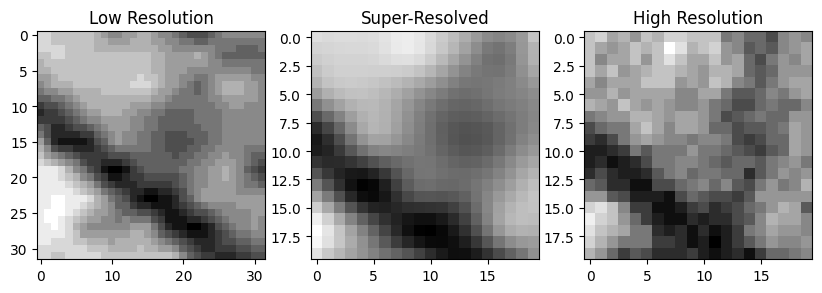

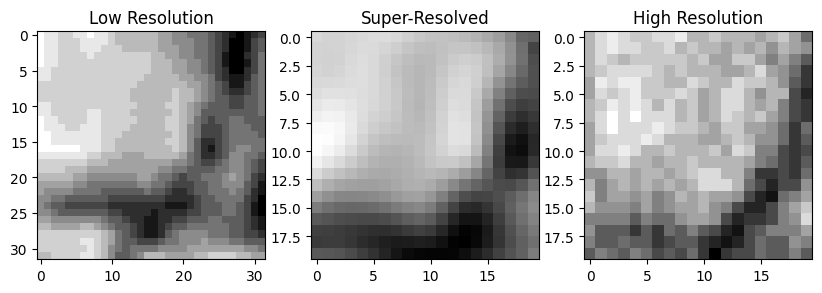

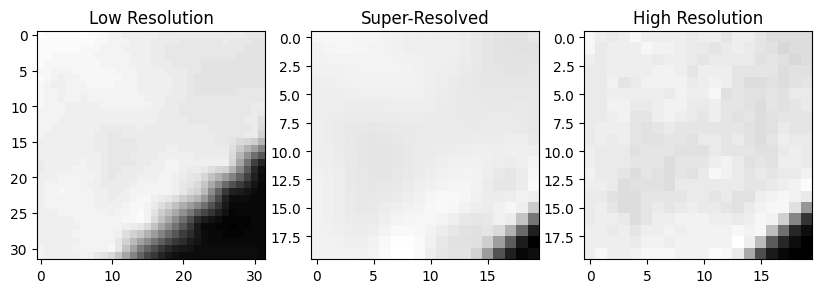

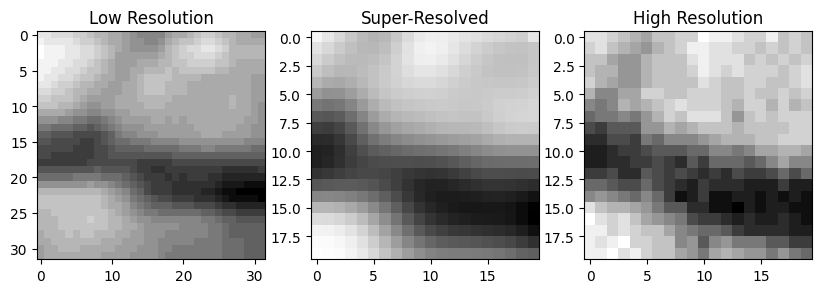

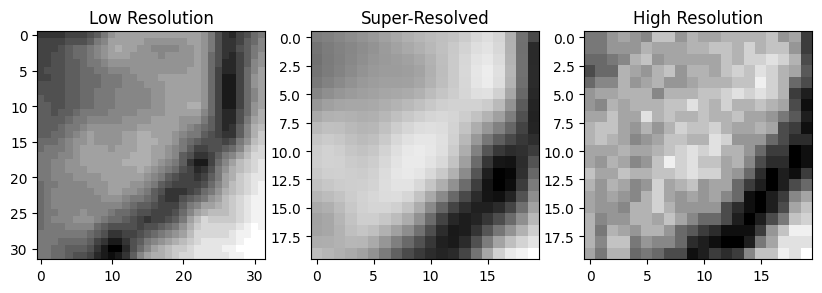

In [79]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Define a counter to control the number of images to visualize
num_images_to_visualize = 5
image_counter = 0

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Visualize images
        for i in range(len(outputs)):
            if image_counter >= num_images_to_visualize:
                break  # Stop visualization after displaying the specified number of images

            # Convert tensors to numpy arrays
            lr_img = inputs[i].squeeze().cpu().numpy()
            hr_img = labels[i].squeeze().cpu().numpy()
            sr_img = outputs[i].squeeze().cpu().numpy()

            # Plot LR, SR, and HR images
            plt.figure(figsize=(10, 6))

            # Plot LR image
            plt.subplot(1, 3, 1)
            plt.imshow(lr_img, cmap='gray')
            plt.title('Low Resolution')

            # Plot SR image
            plt.subplot(1, 3, 2)
            plt.imshow(sr_img, cmap='gray')
            plt.title('Super-Resolved')

            # Plot HR image
            plt.subplot(1, 3, 3)
            plt.imshow(hr_img, cmap='gray')
            plt.title('High Resolution')

            plt.show()

            image_counter += 1
